# cs7324 Lab 7 - Sequential Networks

#### Chip Henderson - 48996654 


## Preparation

In this lab, I'll be using a collection of Tweets related to the coronavirus pandemic. My intent is to use Convolutional Neural Network and Transformer models to analyze sentiment.

Source: https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification

### Data Import and Tokenization

My dataset is already split into training and testing categories. Since I will need to split out my y values as well, and I'd like to see some distributions before agreeing with the split somoeone else came up with, I'm going to combine the two.

In [28]:
# Import everything
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import Embedding, Input, Concatenate
from tensorflow.keras.layers import Subtract
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [29]:
from tensorflow.keras.preprocessing import sequence

# I'm using a latin enoding because there are some special characters
df_train = pd.read_csv(r'C:\Users\Chip\source\repos\cs7324_code\Data_Sources\Coronavirus_tweets\Corona_NLP_train.csv',encoding='iso-8859-1')
df_test = pd.read_csv(r'C:\Users\Chip\source\repos\cs7324_code\Data_Sources\Coronavirus_tweets\Corona_NLP_test.csv',encoding='iso-8859-1')

df_covid = pd.concat([df_train, df_test])

df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44955 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 1   ScreenName     44955 non-null  int64 
 2   Location       35531 non-null  object
 3   TweetAt        44955 non-null  object
 4   OriginalTweet  44955 non-null  object
 5   Sentiment      44955 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.4+ MB


#### Dimensionality Reduction

At a glance of the examples above. There are some characters that I'm not sure I want to include in my embeddings. Some are stop words like "a," "the," "is," "are." Others are @tags that I don't believe will help my sentiment predictions. When I tokenize these Tweets I'm going to remove the stop words and will examine some differences in leaving the @tags in or removing them. Idea behind this is that I further reduce dataset complexity by removing these words that don't add value to prediction.

Here, I'm goign to do the initial removal of stop words and @tags. I'll come back to Tokenization after doing some more cleanup.

In [30]:
''' This works, trying something else for now
%%time
# Source: Modified from in-class lecture notebook 13a
# Source: Previous code written for cs7320 NLP

import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

# Createa a regex to catch @tags
pattern = r'@\w+'

# Function to tokenize and remove stopwords
def tokenize_and_remove_stopwords(tweet):
    no_tags = re.sub(pattern,'',tweet)
    tokens = word_tokenize(no_tags)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

# Apply tokenization and stop word removal to the 'OriginalTweet' column
df_covid['OriginalTweet'] = df_covid['OriginalTweet'].apply(tokenize_and_remove_stopwords)

print(df_covid)
'''

' This works, trying something else for now\n%%time\n# Source: Modified from in-class lecture notebook 13a\n# Source: Previous code written for cs7320 NLP\n\nimport nltk\nimport re\nnltk.download(\'punkt\')\nnltk.download(\'stopwords\')\nfrom nltk import word_tokenize\nfrom nltk.corpus import stopwords\n\nstop_words = set(stopwords.words("english"))\n\n# Createa a regex to catch @tags\npattern = r\'@\\w+\'\n\n# Function to tokenize and remove stopwords\ndef tokenize_and_remove_stopwords(tweet):\n    no_tags = re.sub(pattern,\'\',tweet)\n    tokens = word_tokenize(no_tags)\n    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]\n    return \' \'.join(filtered_tokens)\n\n# Apply tokenization and stop word removal to the \'OriginalTweet\' column\ndf_covid[\'OriginalTweet\'] = df_covid[\'OriginalTweet\'].apply(tokenize_and_remove_stopwords)\n\nprint(df_covid)\n'

In [31]:
import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

# Createa a regex to catch @tags
pattern = r'@\w+'

stop_words = set(stopwords.words("english"))

def remove_tags_and_stop_words(tweet):
    no_tags = re.sub(pattern,'',tweet)
    no_stop_words = [word for word in no_tags.split() if word not in stop_words]
    return ' '.join(no_stop_words)


# Apply the pattern to remove those tags from tweets
df_covid['OriginalTweet'] = df_covid['OriginalTweet'].apply(remove_tags_and_stop_words)

print(df_covid['OriginalTweet'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Chip\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Chip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0       https://t.co/iFz9FAn2Pa https://t.co/xX6ghGFzC...
1       advice Talk neighbours family exchange phone n...
2       Coronavirus Australia: Woolworths give elderly...
3       My food stock one empty... PLEASE, panic, THER...
4       Me, ready go supermarket #COVID19 outbreak. No...
                              ...                        
3793    Meanwhile In A Supermarket Israel -- People da...
3794    Did panic buy lot non-perishable items? ECHO n...
3795    Asst Prof Economics talking recent research co...
3796    Gov need somethings instead biar je rakyat ass...
3797    I members committed safety employees end-users...
Name: OriginalTweet, Length: 44955, dtype: object


Because of the memory footprint and compute times for some of these networks, I'm going to make my dataset as simple as possible. Also, I'm focused on performing a many-to-one analysis. Therefore, I'll be dropping everything except for the Original Tweet and Sentiment columns. 

In [32]:
features_to_keep = ['OriginalTweet', 'Sentiment']
features_to_drop = [feature for feature in df_covid.columns if feature not in features_to_keep]

# Drop features I won't be using for this lab
df_covid_reduced = df_covid.drop(features_to_drop,axis=1)

# Determine number of instances 
df_covid_reduced.value_counts

<bound method DataFrame.value_counts of                                           OriginalTweet           Sentiment
0     https://t.co/iFz9FAn2Pa https://t.co/xX6ghGFzC...             Neutral
1     advice Talk neighbours family exchange phone n...            Positive
2     Coronavirus Australia: Woolworths give elderly...            Positive
3     My food stock one empty... PLEASE, panic, THER...            Positive
4     Me, ready go supermarket #COVID19 outbreak. No...  Extremely Negative
...                                                 ...                 ...
3793  Meanwhile In A Supermarket Israel -- People da...            Positive
3794  Did panic buy lot non-perishable items? ECHO n...            Negative
3795  Asst Prof Economics talking recent research co...             Neutral
3796  Gov need somethings instead biar je rakyat ass...  Extremely Negative
3797  I members committed safety employees end-users...  Extremely Positive

[44955 rows x 2 columns]>

From the example above I see there are a few different sentiments as target values. I'll look at these in more detail because I may want to just make this as few classes as possible (positive/negative/Netral) instead of trying to predict the degree to which something is positive or negative. 

Predicting how positive or how negative a Tweet is would be diving more deeply into sentiment analysis as opposed to focusing on creating the neural networks to train on this data, so I'm considering it beyond the scope of this lab.

In [33]:
# How many unique target values are there?
print(df_covid_reduced.Sentiment.unique())

['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive']


In [34]:
# Take 'Extremely Positive' and 'Extremely Negative' and make them align with 'Positive' or 'Negative'
df_covid_reduced.loc[df_covid_reduced['Sentiment'] == 'Extremely Negative'] = 'Negative'
df_covid_reduced.loc[df_covid_reduced['Sentiment'] == 'Extremely Positive'] = 'Positive'

print(df_covid_reduced.Sentiment.unique())

['Neutral' 'Positive' 'Negative']


#### Class Distribution

Let's see how the distribution of positive, negative, and neutral appear in the data. The purpose of this is to determine how imbalanced my classes might be. Since the subject matter is Covid-19, I'm going to guess my negatives are going to outweigh things. But we'll see below.

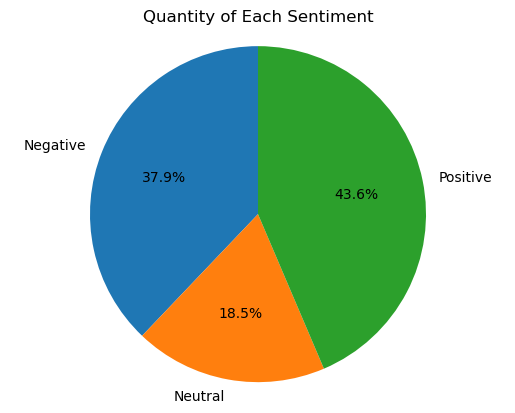

Sentiment
Positive     19592
Negative     17031
Neutral       8332
Name: count, dtype: int64

In [35]:
# Source: Chat-GPT for correcting some pie chart artifacts that were overlapping
# This was done after selecting the pie chart as my method of presenting the data
import matplotlib
import matplotlib.pyplot as plt

sentiments = df_covid_reduced.groupby(['Sentiment'])
pie_data = sentiments.size() # Chat-GPT change

# Chat-GPT recommended adding a startangle and using pie_data instead of 
# using the column name which made the chart too cluttered.
plt.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%', labeldistance=1.1, startangle=90)

plt.title("Quantity of Each Sentiment")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# Get the exact count of each value to provide further information
df_covid_reduced.value_counts(['Sentiment'])

These results didn't align with my expectations, but that's why I'm checking them. I'm usng a pie chart here because its a simple straight forward method for communicating class balance visually. This will help guide decisions on data splitting.

#### Tokenization

Let's see how long my longest tweet is. Depending on when this data was collected the max length could vary.

In [36]:
print(f"The longest tweet from the training data is {len(max(df_covid_reduced['OriginalTweet'], key=len))}")
print(max(df_covid_reduced['OriginalTweet'], key=len))

The longest tweet from the training data is 314
#Oil futures NY jumped 11% $22.54/barrel. More below. Noon prices: #SPX500Â2421.4 #NAS100Â7288.3 #WTIÂ22.41 #GOLDÂ1485.89 #SILVERÂ12.165 Practise trading oil free demo: https://t.co/x9ZztKCodE #coronavirus #COVID19 #COVID2019AU #DonaldTrump #CoronaVirusOutbreak https://t.co/rmjLqCuIFB https://t.co/jcb2OAumGx


Running the code above, it looks like my longest tweet length is 314. Pulling the longest tweet found, I see this is clearly 314 characters, not words. 

This is an interesting datapoint as researching the history of Twitter, the max length was originally 140 characters, later upgraded to 280. (Source: https://developer.twitter.com/en/docs/counting-characters#:~:text=This%20limited%20the%20original%20Tweet,brief%2C%20but%20enabling%20more%20expression.) So, I'm not sure how 314 could have gotten in. Double checking the count in a text editor I confirmed there are 314 characters in the line above. There are a lot of considerations for what constitues one or two characters in a Tweet. Without diving into the details ad nauseum I'll accept the high end of a Tweet can be more than 280 characters.

Curiously, when I ran the first model below with a MAX_TWEET_LENGTH of 314, I had pretty poor performance. My loss functions bottomed out pretty much imediately and stayed there

In [37]:
%%time

NUM_TOP_WORDS = None # use entire vocabulary!
# When running initial tests, setting max to 314 gave poor results
# Subsequently changing this to an arbitrary 500 to see if that improves things
MAX_TWEET_LEN = 500  # maximum and minimum number of words

#tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(df_covid_reduced['OriginalTweet'])
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(df_covid_reduced['OriginalTweet'])

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_TWEET_LEN)
y = df_covid_reduced.Sentiment.values
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y.shape)
print(np.max(X))


Found 60999 unique tokens. Distilled to 60999 top words.
Shape of data tensor: (44955, 500)
Shape of label tensor: (44955,)
60999
CPU times: total: 1.67 s
Wall time: 2.04 s


#### Metrics

Sources: 
 -  https://medium.com/analytics-vidhya/precision-recall-tradeoff-for-real-world-use-cases-c6de4fabbcd0
 -  https://www.analyticsvidhya.com/blog/2021/06/twitter-sentiment-analysis-a-nlp-use-case-for-beginners/#:~:text=Twitter%20sentiment%20analysis%20analyzes%20the,neutral%20based%20on%20their%20content.


I'm going to be treating this model as a recommender. The business case for a recommender is that the results of the model should align with enabling a user to make an informed decision or take some direct action as a result of the recommendation. The Covid-19 crisis affected the public greatly, and the policy decisions of government and health organizations had a direct impact on that. If a public relations (PR) firm hired by government officials or health organizations wanted to be able to understand whether messaging was effective, they might turn to an analysis of social media.

Tweet sentiment analysis allows an organization to understand general sentiment of Twitter (now X) users that may be a good proxy for general population sentiment towards actions taken in response to the Covid-19 outbreak. Because I want a PR firm to be able to provide effective feedback to governmental or health organization leaders, I want the model to focus on precision. Using precision allows me to look at each class individually and determine how well my model did to characterize whether the sentiment was negative, neutral, or positive. Doing this helps me understand whether my class predictions have a great deal of false positives. 

False positives in the sense of my business case, could lead someone to make a decision that is actually counter to what the data is telling them. If I have made policy decisions that are received very negatively, the PR team might want to alter the messaging so people understand the reasoning better (that is, if the policy decision is necessary for public health for example). If I have a handful of false negatives, positive tweets that end up in the negative or neutral predited classes, that isn't overly harmful to my prediction task. However, if I'm trying to understand whether my policy is viewed a particular way, I don't want many false positives getting into my class of interest.

#### Data Split

I'm surprised that we have so many positive tweets but they're relatively close to negative quantities. Neutrals are the least represented category. Based on the quantities in each classification, I believe I'm going to want to stratify this data to ensure I have an equal representation in my training and test data. I'll do that below and check the results.

In [38]:


# Get basic X and y datasets
# X = df_covid_reduced.OriginalTweet.values
# y = df_covid_reduced.Sentiment.values

# Split my data in to training and test 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size=0.2, stratify=y)

# Let's double check the distributions to make sure that stratify has done what I wanted
# Source:https://stackoverflow.com/questions/10741346/frequency-counts-for-unique-values-in-a-numpy-array

# Get the counts of unique values in training data
unique_train_classes, counts = np.unique(y_train, return_counts=True)

# Calculate the total number of elements in the array
total_elements = len(y_train)

# Calculate the percentage of total for each count
percentages = (counts / total_elements) * 100

print(np.asarray((unique_train_classes, counts, percentages.round(0))).T, '\n')

# Same as above for test for comparison
unique_test_classes, counts = np.unique(y_test, return_counts=True)
total_elements = len(y_test)
percentages = (counts / total_elements) * 100

# Check and make sure stratify did what I expected it to
print(np.asarray((unique_test_classes, counts, percentages.round(0))).T)



[['Negative' 13625 38.0]
 ['Neutral' 6666 19.0]
 ['Positive' 15673 44.0]] 

[['Negative' 3406 38.0]
 ['Neutral' 1666 19.0]
 ['Positive' 3919 44.0]]


I can tell my percent splits match between training and testing labels, so I can be confident I'm going to test on data like I'm going to train on. Next I'll one-hot encode my label data.

In [39]:

# Use label encoder to get my data into integer form
label_encoder = LabelEncoder()
y_enc_train = label_encoder.fit_transform(y_train)
y_enc_test = label_encoder.fit_transform(y_test)

# One-hot encode the encoded labels
y_train_ohe = keras.utils.to_categorical(y_enc_train)
y_test_ohe = keras.utils.to_categorical(y_enc_test)

# Check the shape of the data and labels to ensure they are correct
print('Shape of data tensor train:', X_train.shape)
print('Shape of data tensor for test:', X_test.shape)
print('Shape of label tensor train:', y_train_ohe.shape)
print('Shape of label tensor for test:', y_test_ohe.shape)

# print(np.max(X))

Shape of data tensor train: (35964, 500)
Shape of data tensor for test: (8991, 500)
Shape of label tensor train: (35964, 3)
Shape of label tensor for test: (8991, 3)


My final dataset prior to modeling has had the following adjustments made:
 -  All features except for the tweets themselves and the categories have been dropped
 -  The labels have been reduced from 5 to 3 by combining Extremely Negative with Negative, and Extremely Positive with Positive. Neutral is unaltered.
 -  The data was split 80/20 train/test, and the data was stratified to maintain the same class distribution in test and train data
 -  The labels have been one-hot encoded
 -  The tweets have been tokenized with stop words and @tags removed, and encoded as integers

Overall I have 3,798 Tweets in my data, each with 3 category possible class labels.

#### Metrics

## Modeling

I'm going to be using the same GLoVE embedding files that were used in the in-class notebook example. I'm working from a Microsoft Surface Pro 8 for most of this lab so I'm somewhat resource limited. So I'm going to be using a 50 sized embedding parameter.

In [72]:
%%time
# Source: Modified from in-class lecture notebook 13a
EMBED_SIZE = 50
# the embed size should match the file you load glove from
embeddings_index = {}
f = open(r'C:\Users\Chip\source\repos\cs7324_code\Data_Sources\glove.6B\glove.6B.50d.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])

Found 400000 word vectors.
Embedding Shape: (61000, 50) 
 Total words found: 26106 
 Percentage: 42.79672131147541
CPU times: total: 5.55 s
Wall time: 5.93 s


In [42]:
# Source: Modified from in-class notebook 13a
# save this embedding now
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_TWEET_LEN,
                            trainable=False)

#### Convolutional Neural Network 1 (CNN-1)

The first CNN I'll run will consist of 64 filters, 5 features wide. I'm changing the filter size from the in-class example because my dataset is quite a bit smaller. So my thought being I won't need so many filters to get good results.

In [ ]:
'''
# debug

# Source: Modified from in-class lecture, notebook 13a
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
# from tensorflow.keras.layers import Dense, Input, Dropout
# from tensorflow.keras.layers import Embedding

EMBED_SIZE = 50  # same size as loaded from GLOVE
NUM_CLASSES = 3
sequence_input = Input(shape=(MAX_TWEET_LEN,), dtype='int32')
# starting size: 500
embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(64, 5, activation='relu', # changed to 64 from 128
           kernel_initializer='he_uniform')(embedded_sequences)

print(f'Size after conv 1 is {x.shape}')

# after conv, size becomes: 1000-4=996
x = MaxPooling1D(5)(x)# after max pool, 996/5 = 199

print(f"after max pool 1, size is {x.shape}")

x = Dropout(0.2)(x)
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

print(f'Size after conv 2 is {x.shape}')


# new size is 195
x = MaxPooling1D(5)(x) # after max pool, size is 195/5 = 39
print(f"after max pool 2 size is {x.shape}")
x = Dropout(0.2)(x)
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

print(f'Size after conv 3 is {x.shape}')

# after convolution, size becomes 35 elements long
x = MaxPooling1D(5)(x) # this is the size to globally flatten 
print(f"after max pool 3, size is {x.shape}")

# flattened vector max pools across each of the 35 elements
# so vectors is now 128 dimensions (same as num output filters)
x = Flatten()(x)
print(f"after flatten, vector is now {x.shape} dimensions")
x = Dropout(0.2)(x)
print(f"after final dropout size is now {x.shape}")

x = Dense(64, activation='relu',
          kernel_initializer='he_uniform')(x)

preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model = Model(sequence_input, preds)

# if representing as OHE, use categorical_crossentropy
# if representing the class as an integer, use sparse_categorical_crossentropy
model.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop',
              metrics=['precision'])
'''

'\n# debug\n\n# Source: Modified from in-class lecture, notebook 13a\n# from tensorflow.keras.models import Model\n# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense\n# from tensorflow.keras.layers import Dense, Input, Dropout\n# from tensorflow.keras.layers import Embedding\n\nEMBED_SIZE = 50  # same size as loaded from GLOVE\nNUM_CLASSES = 3\nsequence_input = Input(shape=(MAX_TWEET_LEN,), dtype=\'int32\')\n# starting size: 500\nembedded_sequences = embedding_layer(sequence_input) # from previous embedding\nx = Conv1D(64, 5, activation=\'relu\', # changed to 64 from 128\n           kernel_initializer=\'he_uniform\')(embedded_sequences)\n\nprint(f\'Size after conv 1 is {x.shape}\')\n\n# after conv, size becomes: 1000-4=996\nx = MaxPooling1D(5)(x)# after max pool, 996/5 = 199\n\nprint(f"after max pool 1, size is {x.shape}")\n\nx = Dropout(0.2)(x)\nx = Conv1D(64, 5, activation=\'relu\',\n           kernel_initializer=\'he_uniform\')(x)\n\nprint(f\'Size after conv 

In [43]:
# Source: Modified from in-class lecture, notebook 13a
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
# from tensorflow.keras.layers import Dense, Input, Dropout
# from tensorflow.keras.layers import Embedding
from tensorflow.keras.metrics import Precision

EMBED_SIZE = 50  # same size as loaded from GLOVE
NUM_CLASSES = 3
sequence_input = Input(shape=(MAX_TWEET_LEN,), dtype='int32')
# starting size: 500
embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, size becomes: 500-4=496
x = MaxPooling1D(5)(x) # after max pool, 996/5 = 99
x = Dropout(0.2)(x) # after dropout, size is 95
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 195
x = MaxPooling1D(5)(x) # after max pool, size is 95/5 = 19
x = Dropout(0.2)(x)
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# after convolution, size becomes 15 elements long
x = MaxPooling1D(5)(x) # this is the size to globally flatten, 15/5 = 3
# flattened vector max pools across each of the 3 elements
# so vectors is now 192 dimensions 3*64 = 192
x = Flatten()(x)

x = Dropout(0.2)(x)
x = Dense(64, activation='relu',
          kernel_initializer='he_uniform')(x)

preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model_cnn_1 = Model(sequence_input, preds)

# if representing as OHE, use categorical_crossentropy
# if representing the class as an integer, use sparse_categorical_crossentropy
model_cnn_1.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop',
              metrics=['Precision'])

print(model_cnn_1.summary())

cnn1_histories = []
tmp = model_cnn_1.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe),
          epochs=10, batch_size=128)
cnn1_histories.append(tmp)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 50)           3050000   
                                                                 
 conv1d (Conv1D)             (None, 496, 64)           16064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 99, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 99, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 95, 64)            20544     
                                                             

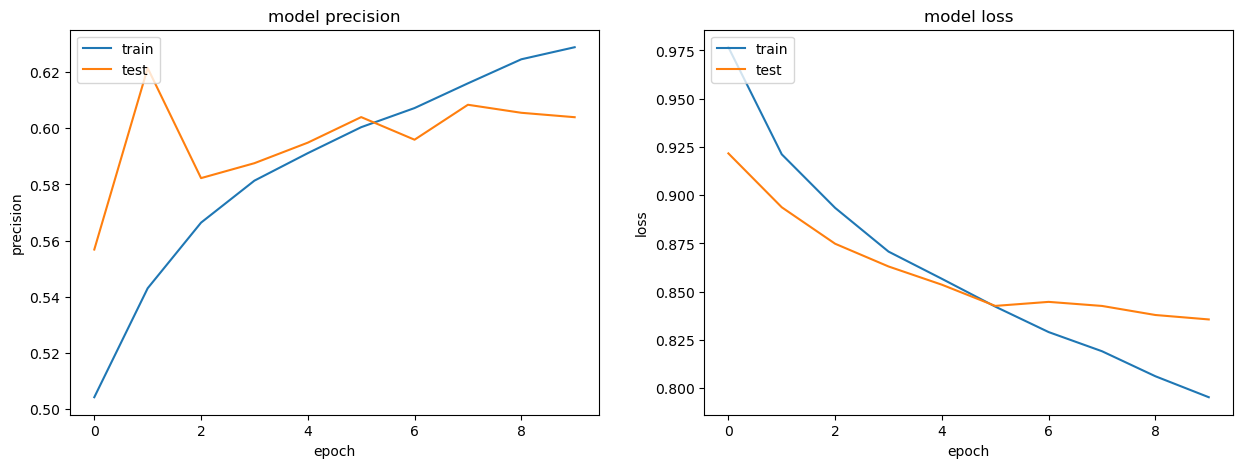

In [44]:

# from sklearn import metrics as mt
# from matplotlib import pyplot as plt
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in cnn1_histories])
    
# summarize history for precision
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision'])
plt.plot(combined['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Convolutional Neural Network 2 (CNN-2)

For this CNN I'm going to see the result with even fewer filters, so I'll be using 32. Also, Tweets are relatively short to begin with, and I've already removed stopwords, so I'd like to see what a smaller filter size might do to my results. Therefore I'm going to use a filter size of 3. Finally, I'm also changing my optimizer to 'Adam'. 

In [59]:
'''
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import Embedding

EMBED_SIZE = 50  # same size as loaded from GLOVE
NUM_CLASSES = 3
sequence_input = Input(shape=(MAX_TWEET_LEN,), dtype='int32')
# starting size: 500
embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(128, 5, activation='relu', # changed to 64 from 128
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, size becomes: 1000-4=996
x = MaxPooling1D(5)(x)# after max pool, 996/5 = 199
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 195
x = MaxPooling1D(5)(x) # after max pool, size is 195/5 = 39
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# after convolution, size becomes 35 elements long
x = MaxPooling1D(5)(x) # this is the size to globally flatten 
# flattened vector max pools across each of the 35 elements
# so vectors is now 128 dimensions (same as num output filters)
x = Flatten()(x)
x = Dropout(0.1)(x) # cut final drop out in half
x = Dense(128, activation='relu',
          kernel_initializer='he_uniform')(x)

preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model_cnn_2 = Model(sequence_input, preds)

# if representing as OHE, use categorical_crossentropy
# if representing the class as an integer, use sparse_categorical_crossentropy
model_cnn_2.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['Precision'])

print(model_cnn_2.summary())

cnn2_histories = []
tmp = model_cnn_2.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe),
          epochs=15, batch_size=128)
cnn2_histories.append(tmp)
'''

"\nfrom tensorflow.keras.models import Model\nfrom tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense\nfrom tensorflow.keras.layers import Dense, Input, Dropout\nfrom tensorflow.keras.layers import Embedding\n\nEMBED_SIZE = 50  # same size as loaded from GLOVE\nNUM_CLASSES = 3\nsequence_input = Input(shape=(MAX_TWEET_LEN,), dtype='int32')\n# starting size: 500\nembedded_sequences = embedding_layer(sequence_input) # from previous embedding\nx = Conv1D(128, 5, activation='relu', # changed to 64 from 128\n           kernel_initializer='he_uniform')(embedded_sequences)\n\n# after conv, size becomes: 1000-4=996\nx = MaxPooling1D(5)(x)# after max pool, 996/5 = 199\nx = Dropout(0.2)(x)\nx = Conv1D(128, 5, activation='relu',\n           kernel_initializer='he_uniform')(x)\n\n# new size is 195\nx = MaxPooling1D(5)(x) # after max pool, size is 195/5 = 39\nx = Dropout(0.2)(x)\nx = Conv1D(128, 5, activation='relu',\n           kernel_initializer='he_uniform')(x)\n\n# after convolu

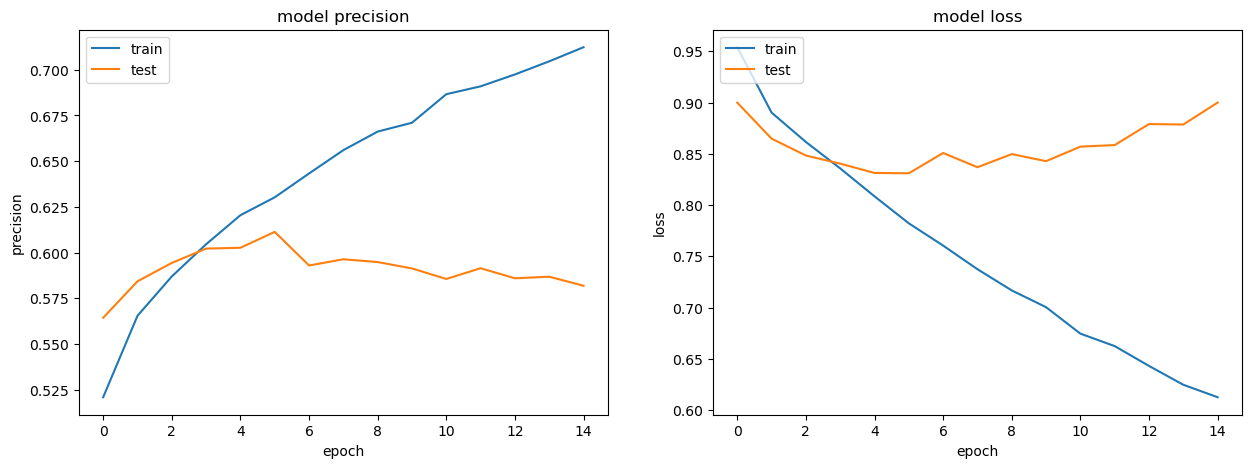

In [51]:
'''
# from sklearn import metrics as mt
# from matplotlib import pyplot as plt
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in cnn2_histories])
    
# summarize history for precision
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision'])
plt.plot(combined['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
'''

#### CNN 2 with Varaince Pooling

I'm going to try a model that utilizes variance pooling next. I'm also changing my optimizer to adam to see if that improves perofrmance at all.

In [60]:
# Source: Modified from in class notebook 13a

EMBED_SIZE = 50  # same size as loaded from GLOVE
sequence_input = Input(shape=(MAX_TWEET_LEN,), dtype='int32')
# starting size: 1000
embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, size becomes: 1000-4=996
x = MaxPooling1D(5)(x)# after max pool, 996/5 = 199
x = Dropout(0.2)(x)
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 195
x = MaxPooling1D(5)(x) # after max pool, size is 195/5 = 39
x = Dropout(0.2)(x)
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# after convolution, size becomes 15 elements long
# Take the mean of these elements across features, result is 128 elements
x_mean = GlobalAveragePooling1D()(x) # this is the size to globally flatten 

# Take the variance of these elements across features, result is 128 elements
x_tmp = Subtract()([x,x_mean])
x_std = GlobalAveragePooling1D()(x_tmp**2)

x = Concatenate(name='concat_1')([x_mean,x_std])


x = Dense(64, activation='relu',
          kernel_initializer='he_uniform')(x)

x = Dropout(0.2)(x)

preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model_xvec = Model(sequence_input, preds)

# if representing as OHE, use categorical_crossentropy
# if representing the class as an integer, use sparse_categorical_crossentropy
model_xvec.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['Precision'])

print(model_xvec.summary())

model_xvec_histories = []
tmp = model_xvec.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe),
          epochs=10, batch_size=128)
model_xvec_histories.append(tmp)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 500, 50)      3050000     ['input_9[0][0]']                
                                                                                                  
 conv1d_24 (Conv1D)             (None, 496, 64)      16064       ['embedding[8][0]']              
                                                                                                  
 max_pooling1d_20 (MaxPooling1D  (None, 99, 64)      0           ['conv1d_24[0][0]']              
 )                                                                                          

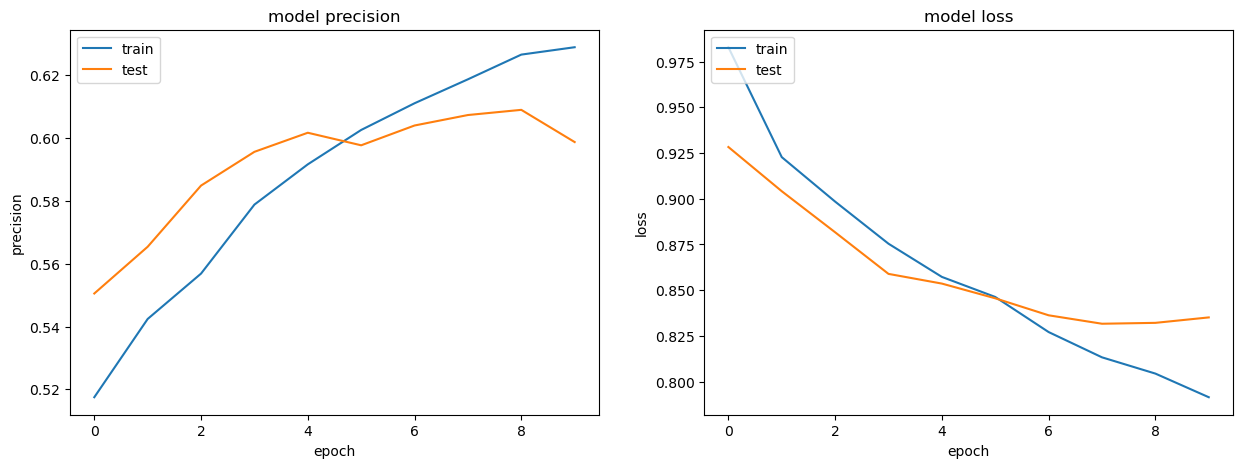

In [61]:

# from sklearn import metrics as mt
# from matplotlib import pyplot as plt
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in model_xvec_histories])
    
# summarize history for precision
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision'])
plt.plot(combined['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Transformer 1

In [85]:
# Source: In-class notebook 13a

from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer

# The transformer architecture 
class TransformerBlock(Layer): # inherit from Keras Layer
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        # setup the model heads and feedforward network
        self.att = MultiHeadAttention(num_heads=num_heads, 
                                      key_dim=embed_dim)
        
        # make a two layer network that processes the attention
        self.ffn = Sequential()
        self.ffn.add( Dense(ff_dim, activation='relu') )
        self.ffn.add( Dense(embed_dim) )
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        # apply the layers as needed (similar to PyTorch)
        
        # get the attention output from multi heads
        # Using same inpout here is self-attention
        # call inputs are (query, value, key) 
        # if only two inputs given, value and key are assumed the same
        attn_output = self.att(inputs, inputs)
        
        # create residual output, with attention
        out1 = self.layernorm1(inputs + attn_output)
        
        # apply dropout if training
        out1 = self.dropout1(out1, training=training)
        
        # place through feed forward after layer norm
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)
        
        # apply dropout if training
        out2 = self.dropout2(out2, training=training)
        #return the residual from Dense layer
        return out2
    
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        # create two embeddings 
        # one for processing the tokens (words)
        self.token_emb = Embedding(input_dim=vocab_size, 
                                   output_dim=embed_dim)
        # another embedding for processing the position
        self.pos_emb = Embedding(input_dim=maxlen, 
                                 output_dim=embed_dim)

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [86]:

# Source: In-class lecture notebook 13a
# first, let's replace the original embedding in the xformer
# with our custom GloVe embedding

class GloveTokenAndPositionEmbedding(Layer):
    def __init__(self):
        super().__init__()
        # create two embeddings 
        # one for processing the tokens, pretrained (words)
        self.token_emb = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_TWEET_LEN,
                            trainable=False)
        
        # another embedding for processing the position
        self.pos_emb = Embedding(MAX_TWEET_LEN, 
                                 EMBED_SIZE, 
                                 input_length=MAX_TWEET_LEN,
                                 trainable=True
                                )

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [87]:
# Source: Modified from in-class lecture notebook 13a

num_heads = 2  # Number of attention heads, trying 2 to start
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
NUM_CLASSES = 3

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model_xformer1 = Model(inputs=inputs, outputs=preds)
print(model_xformer1.summary())

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 500)]             0         
                                                                 
 glove_token_and_position_em  (None, 500, 50)          3075000   
 bedding (GloveTokenAndPosit                                     
 ionEmbedding)                                                   
                                                                 
 transformer_block_6 (Transf  (None, 500, 50)          23832     
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_16  (None, 50)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_53 (Dropout)        (None, 50)                0  

In [88]:
# Source: modified from in-class lecture notebook 13a
model_xformer1.compile(loss='categorical_crossentropy', 
              optimizer='adam', # changed optimizer from rmsprop to adam
              metrics=['Precision']) # changed metric
histories_xformer1 = []
tmp = model_xformer1.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=6, batch_size=128) # Changed batch size from 16 to 128
histories_xformer1.append(tmp)

Epoch 1/6


281/281 [==============================] - 456s 2s/step - loss: 0.8010 - precision: 0.7293 - val_loss: 0.6630 - val_precision: 0.7813
Epoch 2/6
281/281 [==============================] - 449s 2s/step - loss: 0.6668 - precision: 0.7732 - val_loss: 0.6436 - val_precision: 0.7531
Epoch 3/6
281/281 [==============================] - 450s 2s/step - loss: 0.6437 - precision: 0.7789 - val_loss: 0.6142 - val_precision: 0.7923
Epoch 4/6
281/281 [==============================] - 448s 2s/step - loss: 0.6255 - precision: 0.7848 - val_loss: 0.6030 - val_precision: 0.7978
Epoch 5/6
281/281 [==============================] - 443s 2s/step - loss: 0.6157 - precision: 0.7913 - val_loss: 0.6005 - val_precision: 0.7784
Epoch 6/6
281/281 [==============================] - 431s 2s/step - loss: 0.6089 - precision: 0.7948 - val_loss: 0.5948 - val_precision: 0.7892


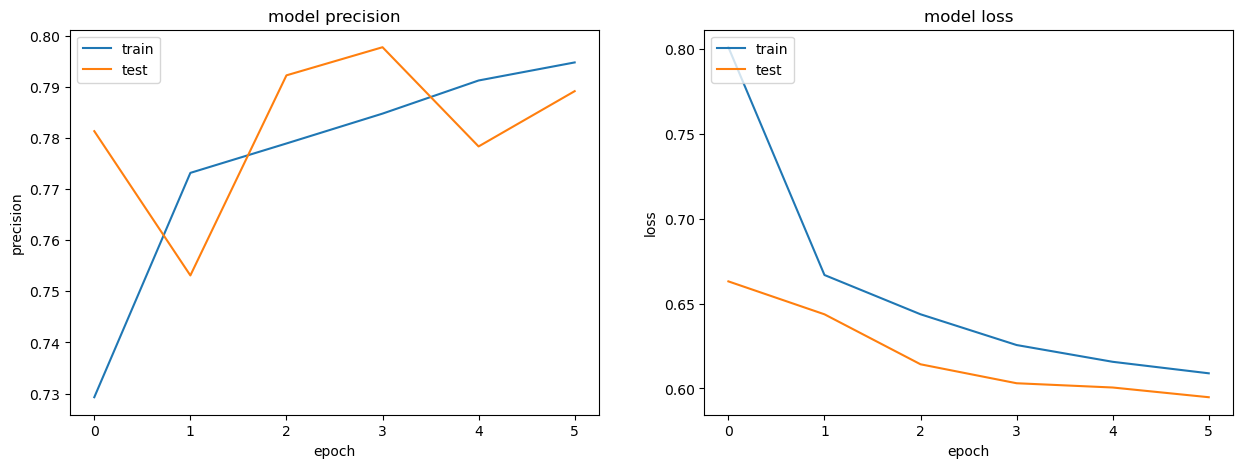

In [89]:
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories_xformer1])
    
# summarize history for precision
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision'])
plt.plot(combined['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [92]:
tmp = model_xformer1.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=2, batch_size=128) # Changed batch size from 16 to 128
histories_xformer1.append(tmp)

Epoch 1/2
281/281 [==============================] - 437s 2s/step - loss: 0.6045 - precision: 0.7937 - val_loss: 0.5952 - val_precision: 0.7907
Epoch 2/2
281/281 [==============================] - 434s 2s/step - loss: 0.6005 - precision: 0.7975 - val_loss: 0.5928 - val_precision: 0.7850


#### Transformer with Extra Layer

In [93]:
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x) # Extra layer added


x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model_xformer_xl = Model(inputs=inputs, outputs=preds)
print(model_xformer_xl.summary())

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 500)]             0         
                                                                 
 glove_token_and_position_em  (None, 500, 50)          3075000   
 bedding_2 (GloveTokenAndPos                                     
 itionEmbedding)                                                 
                                                                 
 transformer_block_9 (Transf  (None, 500, 50)          44132     
 ormerBlock)                                                     
                                                                 
 transformer_block_10 (Trans  (None, 500, 50)          44132     
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_18  (None, 50)               0  

In [94]:
# Source: modified from in-class lecture notebook 13a
model_xformer_xl.compile(loss='categorical_crossentropy', 
              optimizer='adam', # changed optimizer from rmsprop to adam
              metrics=['Precision']) # changed metric
histories_xformer_xl = []
tmp = model_xformer_xl.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=6, batch_size=128) # Changed batch size from 16 to 128
histories_xformer_xl.append(tmp)

Epoch 1/6


281/281 [==============================] - 1614s 6s/step - loss: 0.8018 - precision: 0.7366 - val_loss: 0.6527 - val_precision: 0.7886
Epoch 2/6
281/281 [==============================] - 1652s 6s/step - loss: 0.6629 - precision: 0.7758 - val_loss: 0.6312 - val_precision: 0.7676
Epoch 3/6
281/281 [==============================] - 1650s 6s/step - loss: 0.6378 - precision: 0.7813 - val_loss: 0.6090 - val_precision: 0.7845
Epoch 4/6
281/281 [==============================] - 1649s 6s/step - loss: 0.6216 - precision: 0.7883 - val_loss: 0.6042 - val_precision: 0.7787
Epoch 5/6
281/281 [==============================] - 1643s 6s/step - loss: 0.6047 - precision: 0.7914 - val_loss: 0.5795 - val_precision: 0.7970
Epoch 6/6
281/281 [==============================] - 1638s 6s/step - loss: 0.5869 - precision: 0.7973 - val_loss: 0.5794 - val_precision: 0.7851


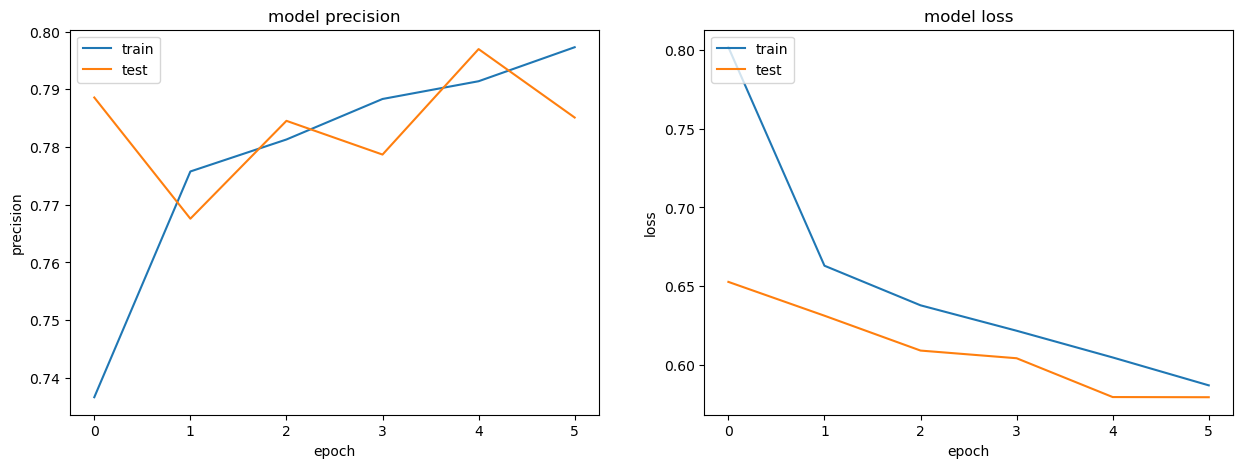

In [96]:
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories_xformer_xl])
    
# summarize history for precision
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision'])
plt.plot(combined['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [97]:
tmp = model_xformer_xl.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=2, batch_size=128) # Changed batch size from 16 to 128
histories_xformer_xl.append(tmp)

Epoch 1/2
281/281 [==============================] - 1650s 6s/step - loss: 0.5770 - precision: 0.8029 - val_loss: 0.5652 - val_precision: 0.7971
Epoch 2/2
281/281 [==============================] - 1651s 6s/step - loss: 0.5625 - precision: 0.8086 - val_loss: 0.5576 - val_precision: 0.8035


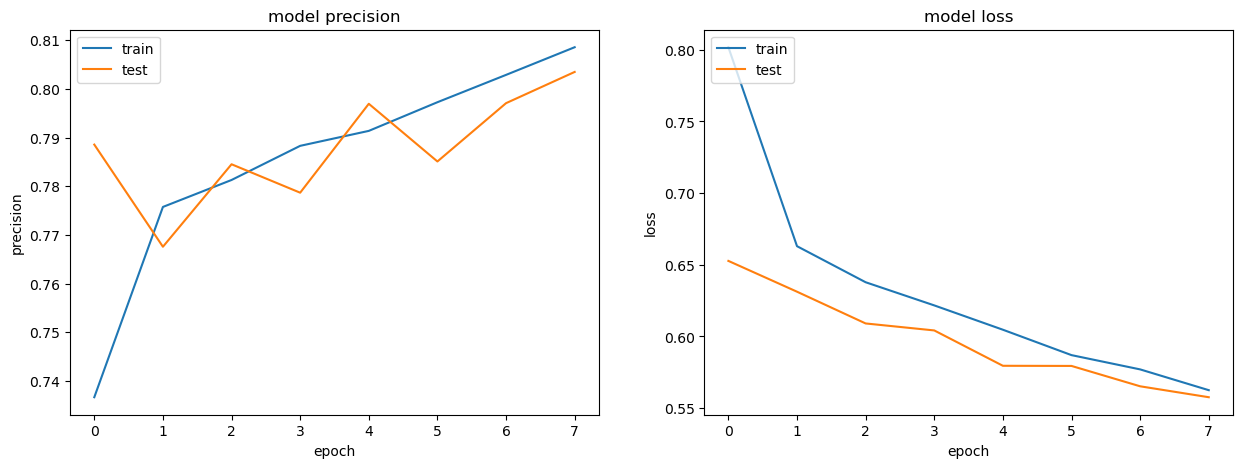

In [98]:
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories_xformer_xl])
    
# summarize history for precision
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision'])
plt.plot(combined['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [99]:
tmp = model_xformer_xl.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=2, batch_size=128) # Changed batch size from 16 to 128
histories_xformer_xl.append(tmp)

Epoch 1/2
281/281 [==============================] - 1651s 6s/step - loss: 0.5543 - precision: 0.8103 - val_loss: 0.5519 - val_precision: 0.8015
Epoch 2/2
281/281 [==============================] - 1627s 6s/step - loss: 0.5485 - precision: 0.8128 - val_loss: 0.5476 - val_precision: 0.8138


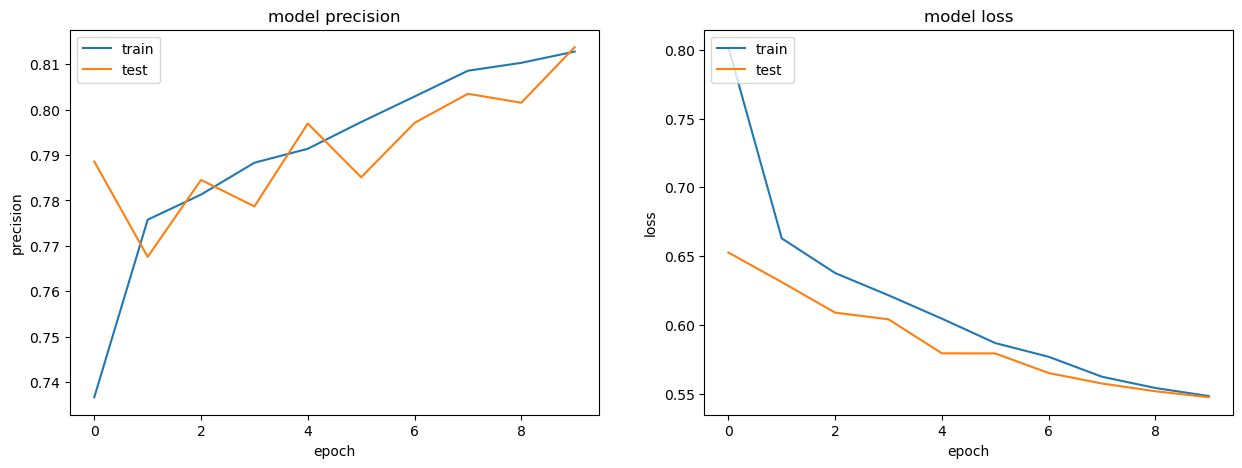

In [100]:
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories_xformer_xl])
    
# summarize history for precision
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision'])
plt.plot(combined['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [101]:
tmp = model_xformer_xl.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=2, batch_size=128) # Changed batch size from 16 to 128
histories_xformer_xl.append(tmp)

Epoch 1/2
281/281 [==============================] - 1665s 6s/step - loss: 0.5421 - precision: 0.8172 - val_loss: 0.5701 - val_precision: 0.7942
Epoch 2/2
281/281 [==============================] - 1648s 6s/step - loss: 0.5347 - precision: 0.8188 - val_loss: 0.5435 - val_precision: 0.8070


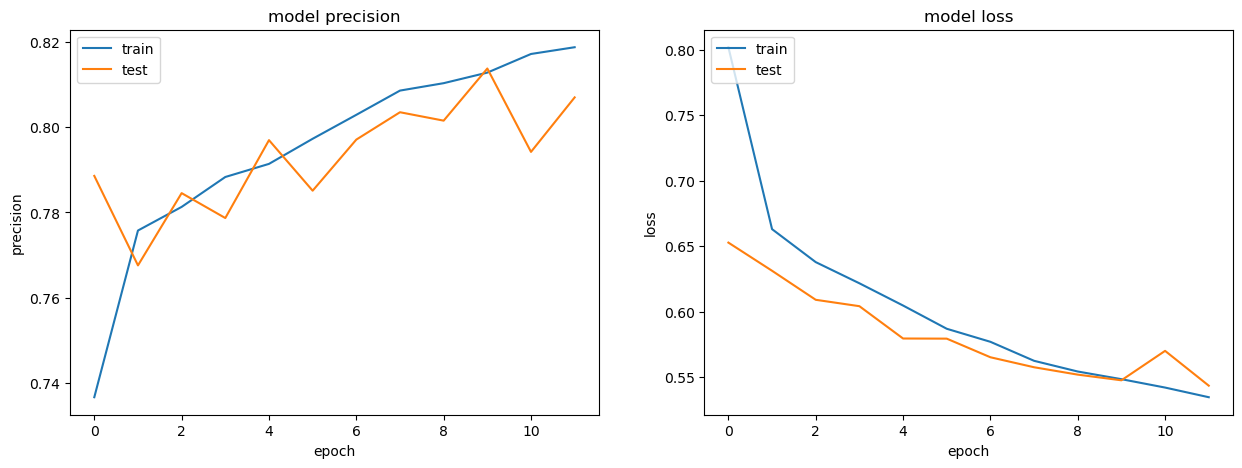

In [102]:
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories_xformer_xl])
    
# summarize history for precision
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision'])
plt.plot(combined['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [103]:
tmp = model_xformer_xl.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=2, batch_size=128) # Changed batch size from 16 to 128
histories_xformer_xl.append(tmp)

Epoch 1/2
281/281 [==============================] - 1650s 6s/step - loss: 0.5274 - precision: 0.8218 - val_loss: 0.5374 - val_precision: 0.8035
Epoch 2/2
281/281 [==============================] - 1647s 6s/step - loss: 0.5215 - precision: 0.8247 - val_loss: 0.5409 - val_precision: 0.8056


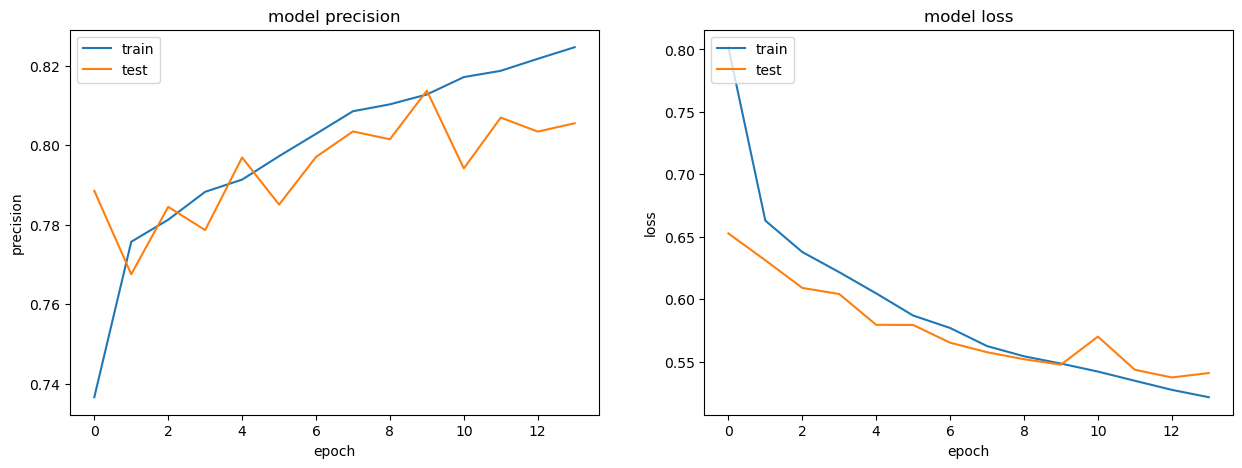

In [104]:
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories_xformer_xl])
    
# summarize history for precision
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision'])
plt.plot(combined['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Transformer 2

In [107]:
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model_xformer2 = Model(inputs=inputs, outputs=preds)
print(model_xformer2.summary())

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 500)]             0         
                                                                 
 glove_token_and_position_em  (None, 500, 50)          3075000   
 bedding_4 (GloveTokenAndPos                                     
 itionEmbedding)                                                 
                                                                 
 transformer_block_12 (Trans  (None, 500, 50)          44132     
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_20  (None, 50)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_73 (Dropout)        (None, 50)                0  

In [108]:
histories_xformer2 = []

# Source: modified from in-class lecture notebook 13a
model_xformer2.compile(loss='categorical_crossentropy', 
              optimizer='adam', # changed optimizer from rmsprop to adam
              metrics=['Precision']) # changed metric
histories_xformer2 = []
tmp = model_xformer2.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=6, batch_size=128) # Changed batch size from 16 to 128
histories_xformer2.append(tmp)

Epoch 1/6


281/281 [==============================] - 855s 3s/step - loss: 0.7973 - precision: 0.7282 - val_loss: 0.6517 - val_precision: 0.7731
Epoch 2/6
281/281 [==============================] - 841s 3s/step - loss: 0.6609 - precision: 0.7724 - val_loss: 0.6429 - val_precision: 0.7606
Epoch 3/6
281/281 [==============================] - 835s 3s/step - loss: 0.6358 - precision: 0.7803 - val_loss: 0.6124 - val_precision: 0.7863
Epoch 4/6
281/281 [==============================] - 835s 3s/step - loss: 0.6189 - precision: 0.7857 - val_loss: 0.6025 - val_precision: 0.7757
Epoch 5/6
281/281 [==============================] - 835s 3s/step - loss: 0.6092 - precision: 0.7898 - val_loss: 0.5955 - val_precision: 0.7876
Epoch 6/6
281/281 [==============================] - 846s 3s/step - loss: 0.6024 - precision: 0.7938 - val_loss: 0.5869 - val_precision: 0.8173


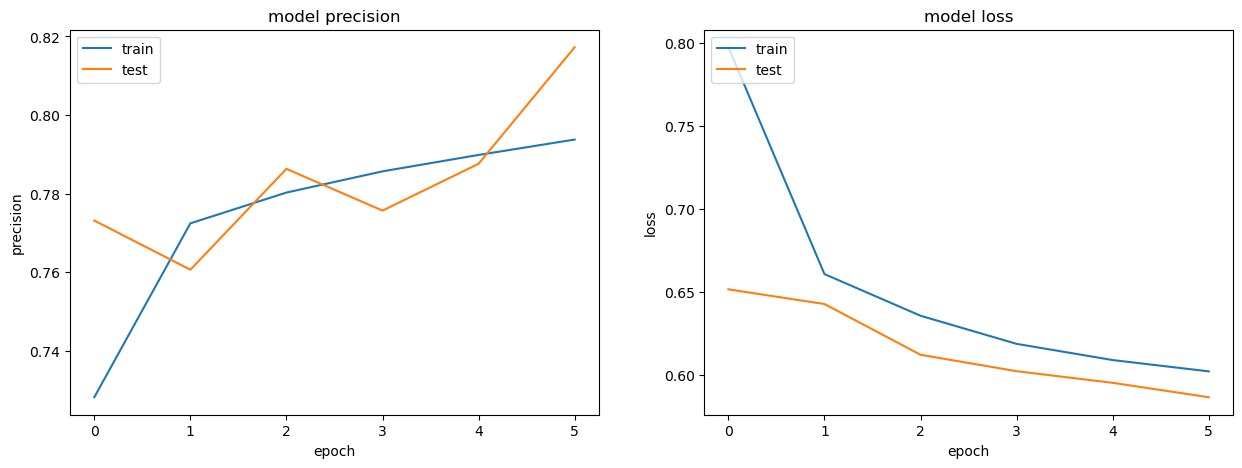

In [111]:
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories_xformer2])
    
# summarize history for precision
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision'])
plt.plot(combined['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [112]:
tmp = model_xformer2.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=2, batch_size=128) # Changed batch size from 16 to 128
histories_xformer2.append(tmp)

Epoch 1/2
281/281 [==============================] - 866s 3s/step - loss: 0.5958 - precision: 0.7971 - val_loss: 0.5797 - val_precision: 0.8115
Epoch 2/2
281/281 [==============================] - 843s 3s/step - loss: 0.5873 - precision: 0.7999 - val_loss: 0.5765 - val_precision: 0.7991


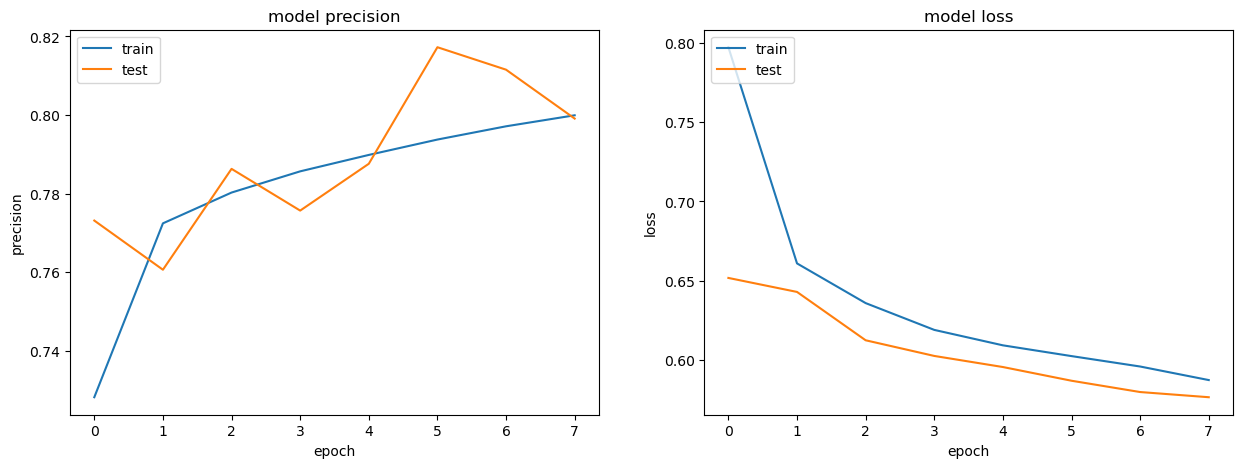

In [113]:
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories_xformer2])
    
# summarize history for precision
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision'])
plt.plot(combined['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [114]:
tmp = model_xformer2.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=2, batch_size=128) # Changed batch size from 16 to 128
histories_xformer2.append(tmp)

%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories_xformer2])
    


Epoch 1/2
281/281 [==============================] - 847s 3s/step - loss: 0.5780 - precision: 0.7999 - val_loss: 0.5765 - val_precision: 0.7922
Epoch 2/2
281/281 [==============================] - 864s 3s/step - loss: 0.5725 - precision: 0.8058 - val_loss: 0.5674 - val_precision: 0.7925


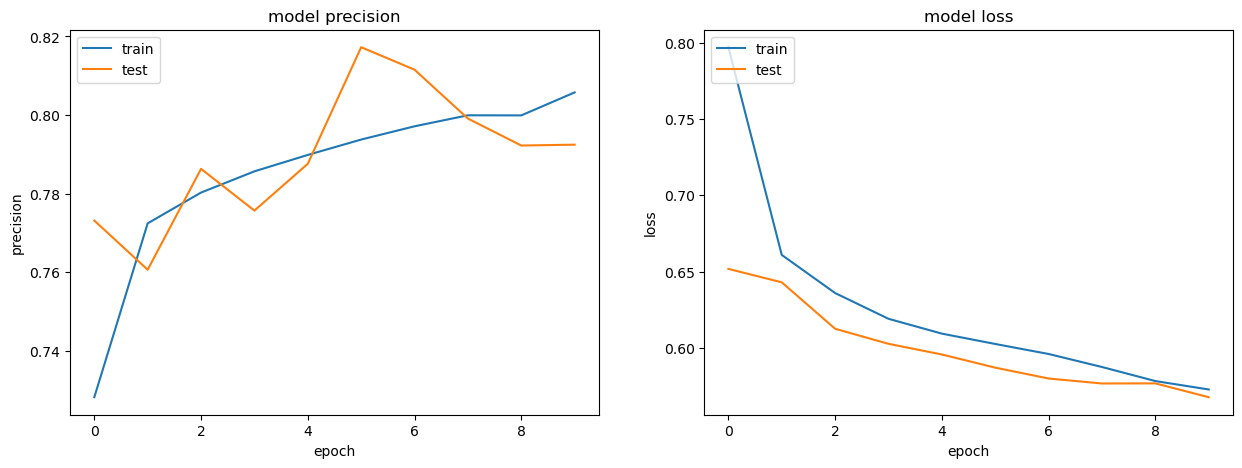

In [115]:
# summarize history for precision
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision'])
plt.plot(combined['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [116]:
tmp = model_xformer2.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=2, batch_size=128) # Changed batch size from 16 to 128
histories_xformer2.append(tmp)

Epoch 1/2
281/281 [==============================] - 946s 3s/step - loss: 0.5685 - precision: 0.8049 - val_loss: 0.5617 - val_precision: 0.8065
Epoch 2/2
281/281 [==============================] - 862s 3s/step - loss: 0.5614 - precision: 0.8104 - val_loss: 0.5657 - val_precision: 0.7881


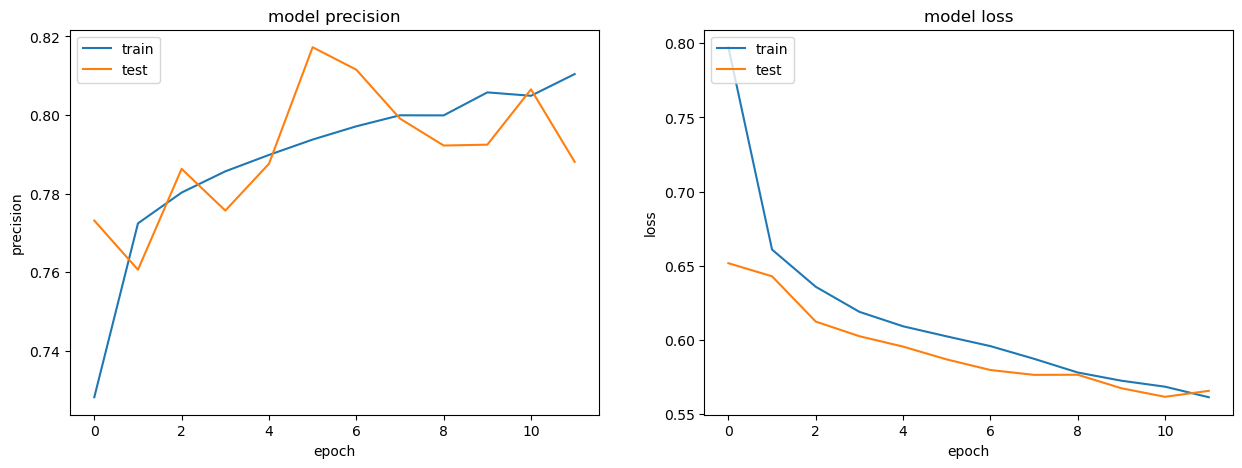

In [117]:
# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories_xformer2])

# summarize history for precision
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision'])
plt.plot(combined['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()